Customized code based on:
https://github.com/jdtoscano94/Learning-Scientific_Machine_Learning_Residual_Based_Attention_PINNs_DeepONets/tree/main/Tutorials/PINNs

# Libraries

In [15]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cuda


### Neural Network

In [16]:
class FCN(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        # x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u
    
    def loss_PDE(self, X_train_Nf):
                        
        g = X_train_Nf.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        u_x_t = autograd.grad(u,g,torch.ones([X_train_Nf.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        # u_xx_tt = autograd.grad(u_x_t,g,torch.ones(X_train_Nf.shape).to(device), create_graph=True)[0]
                                                            
        u_x = u_x_t[:,[0]]
        
        u_t = u_x_t[:,[1]]
        
        # u_xx = u_xx_tt[:,[0]]
                                        
        f = u_t + 1*(u_x) 
        d = 0.12*(abs(u_x)-u_x)  + 1
        
        loss_f = self.loss_function(f/d,f_hat)
                
        return loss_f
    
    def loss(self,x,y,X_train_Nf):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(X_train_Nf)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_train_Nu, U_train_Nu, X_train_Nf)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            # error_vec = loss.item()
        
            print(loss)

        return loss        
    


# Generate data

In [17]:
steps=1001;
lr=1e-2
t1=40
layers = np.array([2,t1,t1,t1,t1,1]) #8 hidden layers


In [18]:
L=30
nx=501

k=100;
c=1
dx = (L+1) / (nx - 1)  # Spatial step size
tmax=L-L/5
c = 1          # Convection speed
sigma = 0.5    # CFL number
dt = sigma * dx / c  # Time step size
nt=int(np.round(tmax/dt))
N_u=nx*nt;
N_f=N_u
# x=np.array([-L/2,-L/3,0,L/4,L/3,L/3.5]).reshape(-1,1)
x=np.linspace(-1,L,nx).reshape(-1,1)
t=np.linspace(0,tmax,nt).reshape(-1,1)
X, T = np.meshgrid(x,t)  
usol=np.tanh((k*(X-c*T)))-np.tanh((k*(X-1-c*T)))
u0=np.tanh((k*(X)))-np.tanh((k*(X-1)))
usol=np.transpose(usol)

## Prepare Data

In [19]:
X_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_test[0]  # [-1. 0.]
ub = X_test[-1] # [1.  0.99]
u_true = usol.flatten('F')[:,None] #Fortran style (Column Major)

## Training Data

In [20]:
'''Boundary Conditions'''

#Initial Condition -1 =< x =<1 and t = 0  
left_X = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
left_U = usol[:,0][:,None]

#Boundary Condition x = -1 and 0 =< t =<1
bottom_X = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
bottom_U = usol[-1,:][:,None]*0

# #Boundary Condition x = 1 and 0 =< t =<1
top_X = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
top_U = usol[-1,:][:,None]*0

X_train = np.vstack([left_X, bottom_X, top_X]) 
U_train = np.vstack([left_U, bottom_U, top_U]) 

#choose random N_u points for training
# idx = np.random.choice(X_train.shape[0], N_u, replace=False) 

X_train_Nu = X_train[:, :] #choose indices from  set 'idx' (x,t)
U_train_Nu = U_train[:,:]      #choose corresponding u

'''Collocation Points'''

# Latin Hypercube sampling for collocation points 
# N_f sets of tuples(x,t)
X_train_Nf = lb + (ub-lb)*lhs(2,N_f) 
X_train_Nf = np.vstack((X_train_Nf, X_train_Nu)) # append training points to collocation points 

# Train Neural Network

In [21]:

'Convert to tensor and send to GPU'
X_train_Nf = torch.from_numpy(X_train_Nf).float().to(device)
X_train_Nu = torch.from_numpy(X_train_Nu).float().to(device)
U_train_Nu = torch.from_numpy(U_train_Nu).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)

PINN = FCN(layers)
       
PINN.to(device)

'Neural Network Summary'
print(PINN)

params = list(PINN.parameters())

'''Optimization'''

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr, 
                              max_iter = steps, 
                              max_eval = None, 
                            #   tolerance_grad = 1e-11, 
                            #   tolerance_change = 1e-11, 
                            #   history_size = 100, 
                              line_search_fn = 'strong_wolfe')


start_time = time.time()
for iter in range(11):
    optimizer.step(PINN.closure)
    # if iter%100==0:
    #       error_vec, _= PINN.test()
    #       print(
    #             'Relative Error(Test): %.5f ' %
    #             (
    #                 error_vec.cpu().detach().numpy(),
                  
    #             )
    #         )
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1-3): 3 x Linear(in_features=40, out_features=40, bias=True)
    (4): Linear(in_features=40, out_features=1, bias=True)
  )
)


### Plots

In [15]:
u_pred = PINN.forward(X_test).cpu().detach().numpy()

In [16]:
u_p=np.reshape(u_pred,(nt,nx))


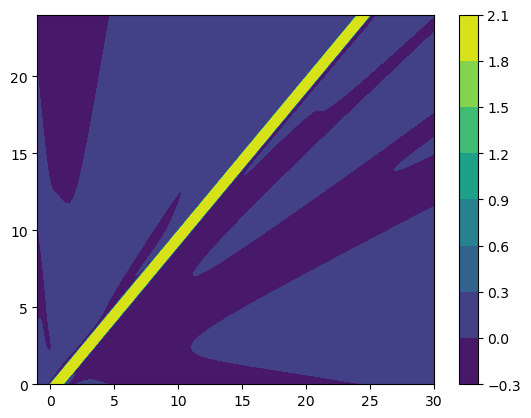

In [17]:
plt.contourf(X,T,u_p)
plt.colorbar()

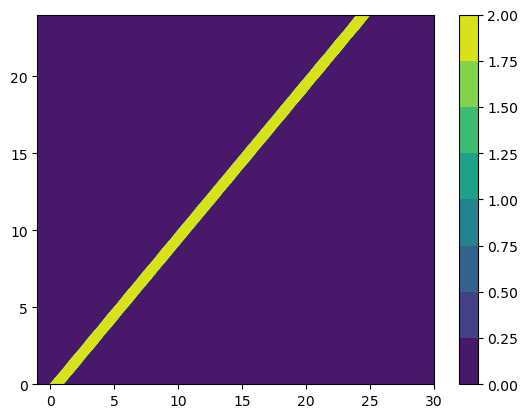

In [18]:
plt.contourf(X,T,np.transpose(usol))
plt.colorbar()

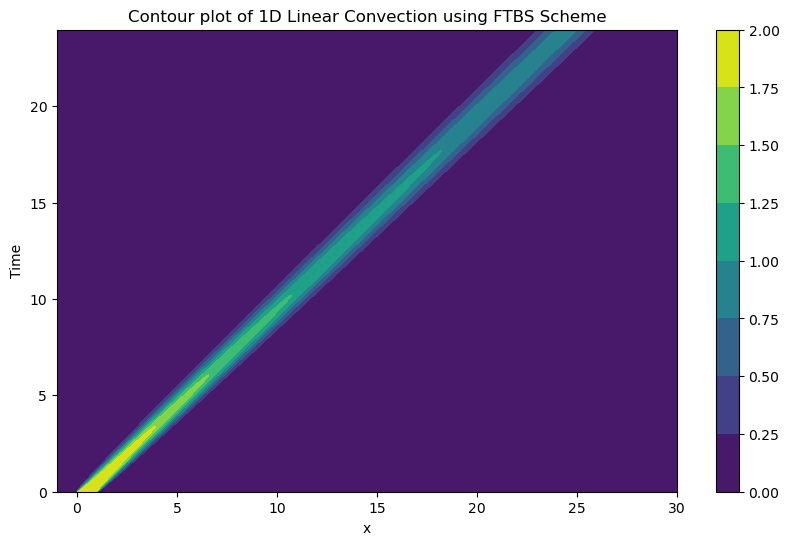

In [19]:
# Initialize the grid and initial condition
x = x.flatten()
u = np.ones(nx)
u= np.tanh(k*(x))-np.tanh(k*(x-1)); # Initial condition: square wave

# Store the solution at each time step
u_all = np.zeros((nt, nx))
u_all[0, :] = u

# FTBS scheme
for n in range(1, nt):  # Time-stepping loop
    un = u.copy()
    for i in range(1, nx):
        u[i] = un[i] - c * dt / dx * (un[i] - un[i - 1])
    u_all[n, :] = u  # Store the solution at this time step

# Plotting the results
X, T = np.meshgrid(x, np.arange(nt) * dt)
plt.figure(figsize=(10, 6))
cp = plt.contourf(X, T, u_all, cmap='viridis')
plt.colorbar(cp)
plt.title('Contour plot of 1D Linear Convection using FTBS Scheme')
plt.xlabel('x')
plt.ylabel('Time')
plt.show()


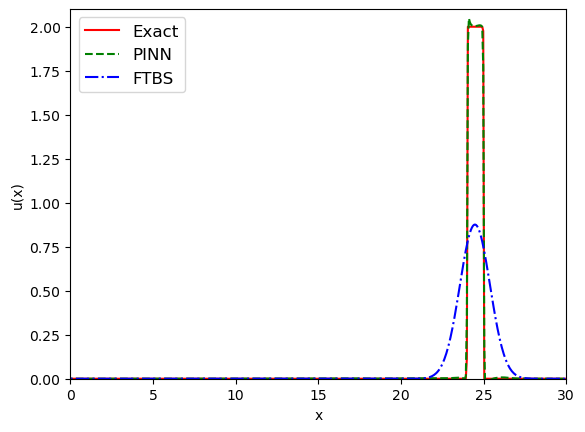

In [20]:
fig, ax1 = plt.subplots()
plt.rcParams.update({'font.size': 12})
ax1.plot(x,usol[:,-1],'r',label='Exact')
ax1.plot(x,u_p[-1,:],'--g',label='PINN')
ax1.plot(x,u,'-.b',label='FTBS')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel("u(x)",color='black')
ax1.legend()
plt.axis([0, 30, 0, 2.1]) 
plt.rc('legend', fontsize=12) 